# The Capital Asset Pricing Model

In [4]:
import numpy as np 
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import scipy.stats as stats
from sklearn import covariance

from statsmodels import regression
import statsmodels.api as sm

from scipy import optimize

import cvxopt as opt
from cvxopt import blas, solvers

import yfinance as yf
import datetime as dt
from dateutil.relativedelta import relativedelta

jtplot.style(figsize=(15, 9))

In [17]:
portfolio = ['AMD', 'AMZN', 'BAC', 'META']

In [31]:
start_date = dt.datetime.now() - relativedelta(years=1)
end_date = dt.datetime.now()

# choose stocks
portfolio_df = yf.download(portfolio, start=start_date, end=end_date, auto_adjust=True)

# risk-free proxy
R_F = yf.download('BIL', start=start_date, end=end_date, auto_adjust=True)

# find it's beta against market
M = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
R = portfolio_df['Close'].sum(axis=1).pct_change()[1:]
R_F = R_F['Close'].pct_change()[1:]
M = M['Close'].pct_change()[1:]

In [33]:
R.rename('portfolio', inplace=True)
R_F.rename('risk_free', inplace=True)
M.rename('beta', inplace=True)

Date
2023-04-26   -0.004236
2023-04-27    0.019908
2023-04-28    0.008535
2023-05-01   -0.001010
2023-05-02   -0.011239
                ...   
2024-04-18   -0.002058
2024-04-19   -0.008728
2024-04-22    0.009209
2024-04-23    0.011867
2024-04-24   -0.000376
Name: beta, Length: 251, dtype: float64

f:\python\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     235.2
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           7.87e-38
Time:                        22:01:23   Log-Likelihood:                 724.30
No. Observations:                 251   AIC:                            -1445.
Df Residuals:                     249   BIC:                            -1438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.279      0.202      -0.001       0.003
beta           1.7880      0.117     15.337      0.000       1.558       2.018
==============================================================================
Omnibus:                      170.224   Durbin-Watson:                   2.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3617.618
Skew:                           2.293   Prob(JB):                         0.00
Kurtosis:                      21.024   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

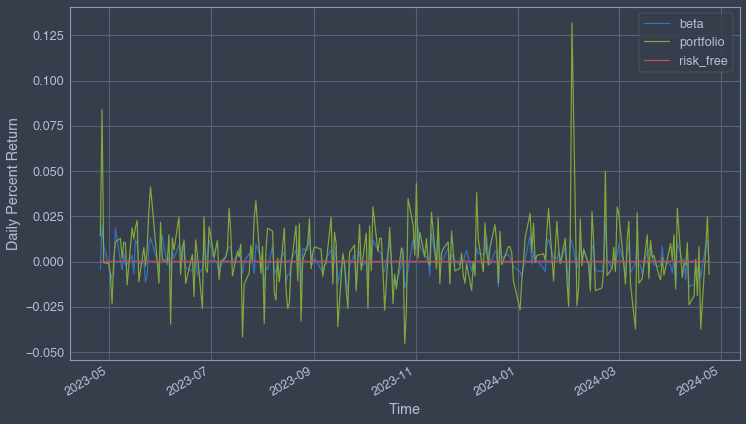

In [34]:
PORTFOLIO_results = regression.linear_model.OLS(R-R_F, sm.add_constant(M)).fit()
PORTFOLIO_beta = PORTFOLIO_results.params[1]

M.plot()
R.plot()
R_F.plot()
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

PORTFOLIO_results.summary()

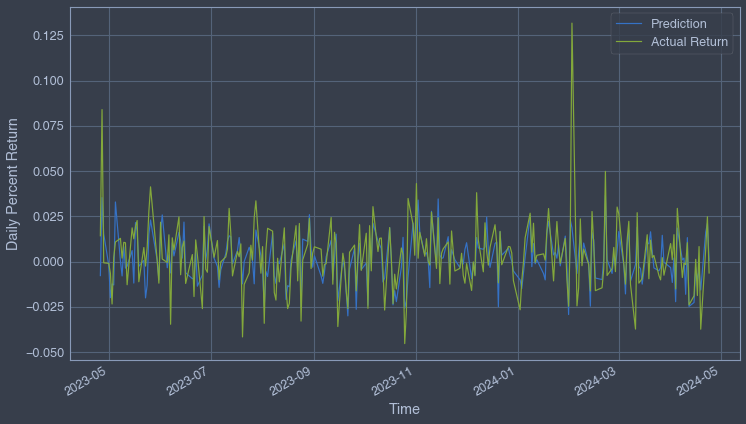

In [27]:
predictions = R_F + PORTFOLIO_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot()
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return');

In [37]:
portfolio_returns = portfolio_df['Close']

In [38]:
for t in portfolio_returns.columns:
    portfolio_returns[f'{t}_returns'] = np.log(portfolio_returns[t].div(portfolio_returns[t].shift(1)))

portfolio_returns.head()

f:\python\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,AMD,AMZN,BAC,META,AMD_returns,AMZN_returns,BAC_returns,META_returns
Date,,,,,,,,
2023-04-25,83.800003,102.570000,27.953634,207.330017,NaN,NaN,NaN,NaN
2023-04-26,85.940002,104.980003,27.565926,209.178055,0.025216,0.023224,-0.013967,0.008874
2023-04-27,87.440002,109.820000,28.002098,238.307144,0.017303,0.045073,0.015699,0.130375
2023-04-28,89.370003,105.449997,28.380112,240.065292,0.021832,-0.040606,0.013409,0.007351
2023-05-01,89.690002,102.050003,28.147490,242.922241,0.003574,-0.032774,-0.008230,0.011830


In [47]:
portfolio_betas = [
    regression.linear_model.OLS(
        portfolio_returns[asset+'_returns'][1:],
        sm.add_constant(M)
    ).fit().params[1]
     for asset in portfolio
]

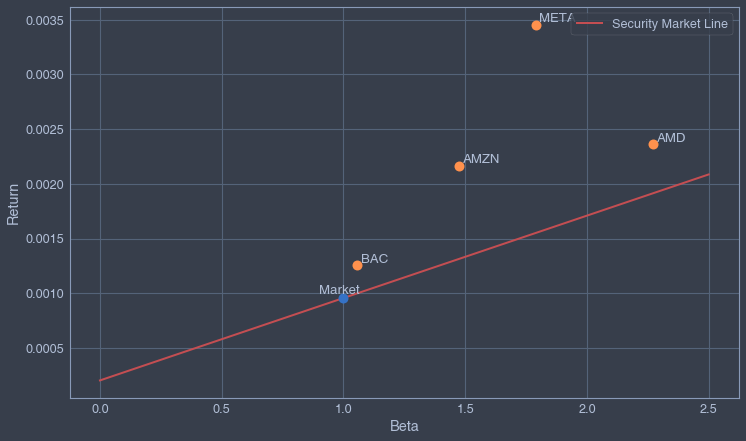

In [58]:
risk_free_rate = np.mean(R_F)

# We have two coordinates that we use to map the SML: (0, risk-free rate) and (1, market return)

eqn_of_the_line = lambda x : ( (np.mean(M)-risk_free_rate) / 1.0) * x + risk_free_rate        
xrange = np.linspace(0., 2.5, num=2)
plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='r', linestyle='-', linewidth=2)

plt.plot([1], [np.mean(M)], marker='o', color='b', markersize=10)
plt.annotate('Market', xy=(1, np.mean(M)), xytext=(0.9, np.mean(M)+0.00004))

for asset, beta in zip(portfolio, portfolio_betas):
    plt.plot([beta], [np.mean(portfolio_returns[asset+'_returns'][1:])], marker='o', color='y', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(portfolio_returns[asset+'_returns'][1:])),
        xytext=(beta + 0.015, np.mean(portfolio_returns[asset+'_returns'][1:]) + 0.000025)
    )

# plt.plot(
#     [portfolio_betas[2], portfolio_betas[2]],
#     [np.mean(portfolio_returns.iloc[:, 3]), eqn_of_the_line(portfolio_betas[2])],
#     color='grey'
# )    
    
plt.xlabel("Beta")
plt.ylabel("Return")

plt.legend(['Security Market Line']);